In [3]:
import torch
import numpy as np
from torch import nn
import os
import csv
from heapq import heappush, heappop
import heapq
import time
from tqdm.auto import tqdm
import gc
import scipy
import scipy.spatial

In [4]:
class SkipGram(nn.Module):
    def __init__(self, word_count, n_dims):
        super(SkipGram, self).__init__()
        self.word_count = word_count
        self.n_dims = n_dims
        
        self.central_emb = nn.Embedding(word_count, self.n_dims, sparse=False)
        self.context_emb = nn.Embedding(word_count, self.n_dims, sparse=False)
        
        initrange = 1.0 / self.n_dims
        torch.nn.init.uniform_(self.central_emb.weight.data, -initrange, initrange)
        torch.nn.init.constant_(self.context_emb.weight.data, 0)
        
        self.central_emb.weight.requires_grad=True
        self.context_emb.weight.requires_grad=True
        
        self.criterion = nn.BCEWithLogitsLoss()
    def forward(self, central, positive, negative):
        central_emb = self.central_emb(central).squeeze()
        positive_emb = self.context_emb(positive).squeeze()
        negative_emb = self.context_emb(negative)
        
        positive_scalar_prod = torch.sum(torch.mul(central_emb, positive_emb), dim=1)
        positive_loss = -nn.functional.logsigmoid(positive_scalar_prod)
        
        negative_scalar_prod = torch.bmm(negative_emb, torch.unsqueeze(central_emb, 2)).squeeze()
        negative_loss = -torch.sum(nn.functional.logsigmoid(-negative_scalar_prod), dim=1)
        
        loss = torch.mean(positive_loss + negative_loss)
        
        return loss

class word_embedd:
    NEGATIVE_TABLE_SIZE = 1e8
    def __init__(self, n_dims):
        self.n_dims = n_dims
    def fit(self, doc_block, batch_size = 5, freq=5, window_size = 2, epochs = 10, \
            lr = 0.01, neg_num = 5):
        
        self.dict     = {}
        self.word2idx = {}
        self.idx2word = {}
        
        for doc in doc_block:        #Counting of frequency of words
            for word in doc:
                self.dict[word] = self.dict.get(word, 0) + 1
                    
        wid=0
        dict_freq = {}
        for word, word_freq in self.dict.items():  #Words goes to dataset if it was met > freq times
            if word_freq < freq:
                continue
            self.idx2word[wid] = word
            self.word2idx[word] = wid
            dict_freq[wid] = word_freq
            wid+=1
        del self.dict
        word_count = len(dict_freq.items())
        
        negatives=[]
        pow_frequency = np.array(list(dict_freq.values())) ** 0.75
        ratio = pow_frequency / sum(pow_frequency)
        count = np.round(ratio * word_embedd.NEGATIVE_TABLE_SIZE)
        for wid, c in enumerate(count):
            negatives += [wid] * int(c)
        negatives = np.array(negatives)
        np.random.shuffle(negatives)
        
        del dict_freq
        
        self.dict = self.word2idx.copy()
        
        self.central_data = []
        self.positive_data = []
        self.negative_data = []
        print("Creating train data")
        for doc in tqdm(doc_block):     #creating trainig dataset
            doc_len = len(doc)
            for i, word in enumerate(doc):
                if not word in self.dict:
                    continue
                curr_word = self.dict[word]
                
                for j in range(i - window_size, i+window_size+1):      #Iteration through window
                    if j != i and j <= doc_len-1 and j >= 0:
                        if doc[j] not in self.dict:
                            continue
                        
                        #positive words and central should not be included in negative words
                        neg_index = []
                        while len(neg_index) < neg_num:
                            _negs = np.random.choice(negatives, size=neg_num - len(neg_index))
                            neg_index += [w for w in _negs if w != i and w != j]
                        neg_index = neg_index[:neg_num]
                        
                        
                        self.central_data.append(self.word2idx[word])
                        self.positive_data.append(self.word2idx[doc[j]])
                        self.negative_data.append(neg_index)
        print("data created")
        
        self.central_data  = np.array(self.central_data)
        self.positive_data = np.array(self.positive_data)
        self.negative_data = np.array(self.negative_data)
        
        print("Training")
        
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = SkipGram(word_count, self.n_dims)
        self.model.to(device)
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        for epo in range(epochs):
            loss_val = 0
            n_batches = int(len(self.central_data)/batch_size)
            for idx in tqdm(range(n_batches)):
                if idx < n_batches:
                    central_words =  self.central_data[idx*batch_size:(idx+1)*batch_size]
                    positive_words = self.positive_data[idx*batch_size:(idx+1)*batch_size]
                    negative_words = self.negative_data[idx*batch_size:(idx+1)*batch_size]
                else:
                    central_words =  self.central_data[idx*batch_size:]
                    positive_words = self.positive_data[idx*batch_size:]
                    negative_words = self.negative_data[idx*batch_size:]
                
                central = torch.autograd.Variable(torch.LongTensor([central_words])).to(device)
                positive = torch.autograd.Variable(torch.LongTensor([positive_words])).to(device)
                negative = torch.autograd.Variable(torch.LongTensor(negative_words)).to(device)

                loss = self.model.forward(central, positive, negative)
                optimizer.zero_grad()
                loss_val += loss.item()
                loss.backward()
                optimizer.step()
                
                gc.collect()
                torch.cuda.empty_cache()
                
            print(f'Loss at epo {epo}: {loss_val/len(self.central_data)}')

        for key in self.dict:
            self.dict[key] = self.model.central_emb(torch.LongTensor([self.word2idx[key]]).to(device))\
                .detach().cpu().numpy()
            
    def remake_dict(self):
        for key in self.dict:
            self.dict[key] = self.model.central_emb(torch.LongTensor([self.word2idx[key]]).to(device))\
                .detach().cpu().numpy()
            
    def get_words(self):
        return [item[0] for item in self.dict.items()]
    
    def get_emb(self, word):
        try:
            return self.dict[word]
        except:
            raise ValueError("word not in vocab")
            
    def save_model(self, dict_path=os.path.join(os.getcwd(), 'dict.npy')):
        np.save(dict_path, self.dict)
        
    def load_model(self, dict_path=os.path.join(os.getcwd(), 'dict.npy')):
        self.dict = np.load(dict_path, allow_pickle=True)[()]
        
    def get_similiar(self, word, k):
        word_emb = self.get_emb(word)
        heap = []
        for key in self.dict:
            if key == word:
                continue
            key_emb = self.dict[key]
            cos_distance = scipy.spatial.distance.cosine(word_emb, key_emb)
            if len(heap) < k:
                heapq.heappush(heap, (-cos_distance, key))
            else:
                heapq.heappushpop(heap, (-cos_distance,key))
        for item in sorted(heap, reverse=True):
            print (-item[0], item[1])



In [5]:
corpus = [['he', 'is', 'a', 'king'],
         ['she', 'is', 'a', 'queen'],
         ['he', 'is', 'a', 'man'],
         ['she', 'is', 'a', 'woman'],
         ['warsaw', 'is', 'poland', 'capital'],
         ['berlin', 'is', 'germany', 'capital'],
         ['paris', 'is', 'france', 'capital']]
embed = word_embedd(5)
embed.fit(corpus, freq = 1, window_size=1, lr=0.001, neg_num=20)

Creating train data



data created
Training



Loss at epo 0: 2.752948760986328



Loss at epo 1: 2.670550686972482



Loss at epo 2: 2.5244854518345425



Loss at epo 3: 2.308029878707159



Loss at epo 4: 2.035663445790609



Loss at epo 5: 1.742873055594308



Loss at epo 6: 1.472417910893758



Loss at epo 7: 1.2537884825751895



Loss at epo 8: 1.0937724454062325



Loss at epo 9: 0.9831131753467378


In [97]:
embed.get_words()

['he',
 'is',
 'a',
 'king',
 'she',
 'queen',
 'man',
 'woman',
 'warsaw',
 'poland',
 'capital',
 'berlin',
 'germany',
 'paris',
 'france']

In [98]:
embed.get_similiar('capital', 4)

0.0024949312210083008 is
0.0046912431716918945 a
0.009616851806640625 woman
0.013037562370300293 king


In [9]:
embed.get_emb('he')

array([[-0.6069864 ,  0.68336576,  0.44893754,  0.8638507 , -0.5472608 ]],
      dtype=float32)

In [26]:
embed.save_model()

In [27]:
embed1 = word_embedd(5)
embed1.load_model()

In [28]:
embed1.get_emb('he')

array([[-0.34441337, -0.521349  ,  0.8406787 ,  0.05467339, -1.0133648 ]],
      dtype=float32)

In [3]:
from sklearn.datasets import fetch_20newsgroups
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import string
import nltk
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import sklearn

In [65]:
train_all = fetch_20newsgroups(subset='train')
print(train_all.target_names, " - 20 возможных тем")

dataset = fetch_20newsgroups(
    subset='train', 
    categories=['comp.sys.mac.hardware', 'soc.religion.christian', 'rec.sport.hockey'])

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']  - 20 возможных тем


In [66]:
def normalize(raw_text):
    raw_text = raw_text.lower().replace('\n', ' ') #lowering and remove \n symbols
    preprocessed_text = re.sub(r'\d+', '', raw_text) #removing digits

    
    regex = re.compile('[%s]' % re.escape(string.punctuation))
    preprocessed_text = regex.sub('', preprocessed_text)       #removing punctuation
    
    preprocessed_text = preprocessed_text.strip() #remove whitespaces
    preprocessed_text = [word for word in preprocessed_text.split(' ') if len(word)]
    
    #стоит использовать остальные пункты для препроцессинга текста. Как удаление стопслов, слов не имеющих смысла.
    
    stop_words = set(stopwords.words('english'))
    preprocessed_text = [word for word in preprocessed_text if not word in stop_words]
    
    #оставить от слов только их начальные формы
    stemmer= PorterStemmer()
    preprocessed_text = [stemmer.stem(word) for word in preprocessed_text]
    lemmatizer=WordNetLemmatizer()
    preprocessed_text = [lemmatizer.lemmatize(word) for word in preprocessed_text]
    
    #Также стоит выбросить некоторые части речи:
    not_suitable_pos = ['CC', 'PRP', 'MD', 'DT']
    #"союзы", местоимения, модальные глаголы, детерминанта соответственно
    
    preprocessed_text = [pair[0] for pair in nltk.pos_tag(preprocessed_text) 
                         if pair[1] not in not_suitable_pos]
    
    return preprocessed_text

data_normalized = [normalize(news) for news in tqdm(dataset.data)]

In [67]:
model = word_embedd(100)

In [108]:
start_time = time.time()
model.fit(data_normalized, epochs=20, neg_num=5, batch_size=1000, freq=5, lr=0.01)
print("--- %s seconds ---" % (time.time() - start_time))

Creating train data


data created
Training


Loss at epo 0: 0.002733520038365823


Loss at epo 1: 0.0022336215423360687


Loss at epo 2: 0.0019773659166068794


Loss at epo 3: 0.0018314171090505614


Loss at epo 4: 0.0017375280607766588


Loss at epo 5: 0.0016802263078288058


Loss at epo 6: 0.0016401525949224182


Loss at epo 7: 0.0016145746345427824


Loss at epo 8: 0.0015955761652506125


Loss at epo 9: 0.001581930072762456


Loss at epo 10: 0.0015710332110016095


Loss at epo 11: 0.001562241008860207


Loss at epo 12: 0.0015539403453597592


Loss at epo 13: 0.0015479778701049116


Loss at epo 14: 0.001542260470123537


Loss at epo 15: 0.001537579394682246


Loss at epo 16: 0.0015342450418909853


Loss at epo 17: 0.0015303166196364664


Loss at epo 18: 0.0015282438911466878


Loss at epo 19: 0.0015254808644160954
--- 2240.29669213295 seconds ---


In [110]:
model.get_similiar('help', 10)

0.5644155144691467 permiss
0.5666289329528809 zia
0.5738573670387268 langloi
0.5946275591850281 appreci
0.6071934700012207 erik
0.6109330058097839 manual
0.6131940186023712 info
0.616569846868515 espn
0.6271063685417175 inform
0.6311157643795013 je


In [109]:
#Data for t-sne visualization

labels = []
embeddings = []
data_to_tsne = [item for sublist in data_normalized[:20] for item in sublist]

for x in list(set(data_to_tsne)):
    try:
        embeddings.append(model.get_emb(x))
        labels.append(x)
    except ValueError:
        continue
embeddings = np.array(embeddings).squeeze()

In [31]:
def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18, 18))  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(label,
                 xy=(x, y),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')

    plt.savefig(filename)

In [32]:
def embeddings_2d(embeddings):
    return TSNE(n_components=2).fit_transform(embeddings)
low_dim_vectors_pca = sklearn.decomposition.PCA(20).fit_transform(embeddings)
low_dim_vectors = embeddings_2d(low_dim_vectors_pca)

d:\programming\python36\venvs\torch\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
d:\programming\python36\venvs\torch\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


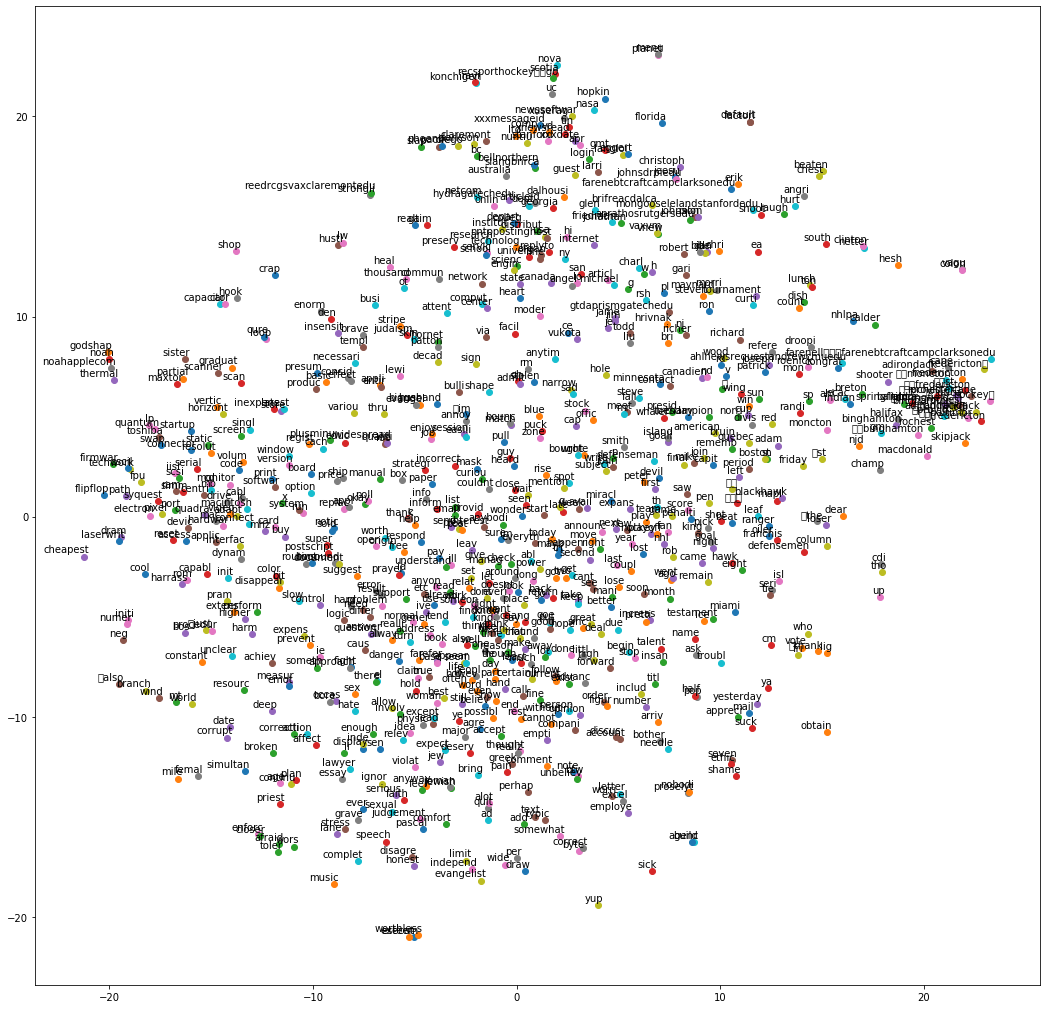

In [115]:
num_words_to_draw = len(labels)
labels_to_draw = [labels[i] for i in range(num_words_to_draw)]
a = plot_with_labels(low_dim_vectors, labels_to_draw)

In [15]:
import gzip
import json

In [45]:
z = gzip.open('wiki150k.zip')

In [46]:
doc_block = []
count = 0
for line in z.readlines():
    if count >= 50000:
        break
    lemmas = json.loads(line)['filtered_lemmas']
    for lemma_block in lemmas:
        doc_block.append(lemma_block)
    count += 1

In [47]:
del z

In [28]:
doc_block[1]

[['masayoshi',
  'nagata',
  'japanese',
  '永',
  '田',
  '雅',
  '宜',
  'nagata',
  'masayoshi',
  'february',
  '9',
  '1927',
  'august',
  '27',
  '2008',
  'japanese',
  'mathematician',
  'know',
  'work',
  'field',
  'commutative',
  'algebra'],
 ['nagata',
  'compactification',
  'theorem',
  'show',
  'variety',
  'can',
  'embed',
  'complete',
  'variety',
  'nagata',
  'theorem',
  'describe',
  'quotient',
  'variety',
  'group',
  '1959',
  'introduce',
  'counterexample',
  'general',
  'case',
  'hilbert',
  'fourteenth',
  'problem',
  'invariant',
  'theory',
  '1962',
  'book',
  'local',
  'ring',
  'contains',
  'several',
  'other',
  'counterexample',
  'find',
  'such',
  'commutative',
  'noetherian',
  'ring',
  'catenary',
  'commutative',
  'noetherian',
  'ring',
  'infinite',
  'dimension',
  'nagata',
  'conjecture',
  'curve',
  'concern',
  'minimum',
  'degree',
  'plane',
  'curve',
  'specify',
  'give',
  'multiplicity',
  'give',
  'point',
  'see',

In [ ]:
w2v = word_embedd(100)
w2v.fit(doc_block, epochs=20, neg_num=5, batch_size=100000, freq=1, lr=0.001)
w2v.save_model()

Creating train data


In [44]:
w2v.get_similiar('hilbert', 10)

0.10055941343307495 spectral
0.10588735342025757 extrinsic
0.10804253816604614 multidimensional
0.11206281185150146 formulation
0.1167600154876709 germline
0.11678934097290039 homology
0.11887919902801514 synthesis
0.1197395920753479 optimization
0.1204453706741333 neurite
0.12163573503494263 nonlinear


In [23]:
w2v.get_words()[:50]

['territory',
 'kongo',
 'central',
 'province',
 'democratic',
 'republic',
 'congo',
 'seat',
 'town',
 'masayoshi',
 'nagata',
 'japanese',
 '永',
 '田',
 '雅',
 '宜',
 'february',
 '9',
 '1927',
 'august',
 '27',
 '2008',
 'mathematician',
 'know',
 'work',
 'field',
 'commutative',
 'algebra',
 'compactification',
 'theorem',
 'show',
 'variety',
 'can',
 'embed',
 'complete',
 'describe',
 'quotient',
 'group',
 '1959',
 'introduce',
 'counterexample',
 'general',
 'case',
 'hilbert',
 'fourteenth',
 'problem',
 'invariant',
 'theory',
 '1962',
 'book']

In [37]:
#Data for t-sne visualization

labels = []
embeddings = []
data_to_tsne = [item for sublist in doc_block[:25] for item in sublist]

for x in list(set(data_to_tsne)):
    try:
        embeddings.append(w2v.get_emb(x))
        labels.append(x)
    except ValueError:
        continue
embeddings = np.array(embeddings).squeeze()

In [40]:
low_dim_vectors_pca = sklearn.decomposition.PCA(20).fit_transform(embeddings)
low_dim_vectors = embeddings_2d(low_dim_vectors_pca)
#low_dim_vectors = embeddings_2d(embeddings)

d:\programming\python36\venvs\torch\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 27704 missing from current font.
  font.set_text(s, 0.0, flags=flags)
d:\programming\python36\venvs\torch\lib\site-packages\matplotlib\backends\backend_agg.py:176: RuntimeWarning: Glyph 27704 missing from current font.
  font.load_char(ord(s), flags=flags)
d:\programming\python36\venvs\torch\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 23452 missing from current font.
  font.set_text(s, 0.0, flags=flags)
d:\programming\python36\venvs\torch\lib\site-packages\matplotlib\backends\backend_agg.py:176: RuntimeWarning: Glyph 23452 missing from current font.
  font.load_char(ord(s), flags=flags)
d:\programming\python36\venvs\torch\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 38597 missing from current font.
  font.set_text(s, 0.0, flags=flags)
d:\programming\python36\venvs\torch\lib\site-packages\matplotlib\bac

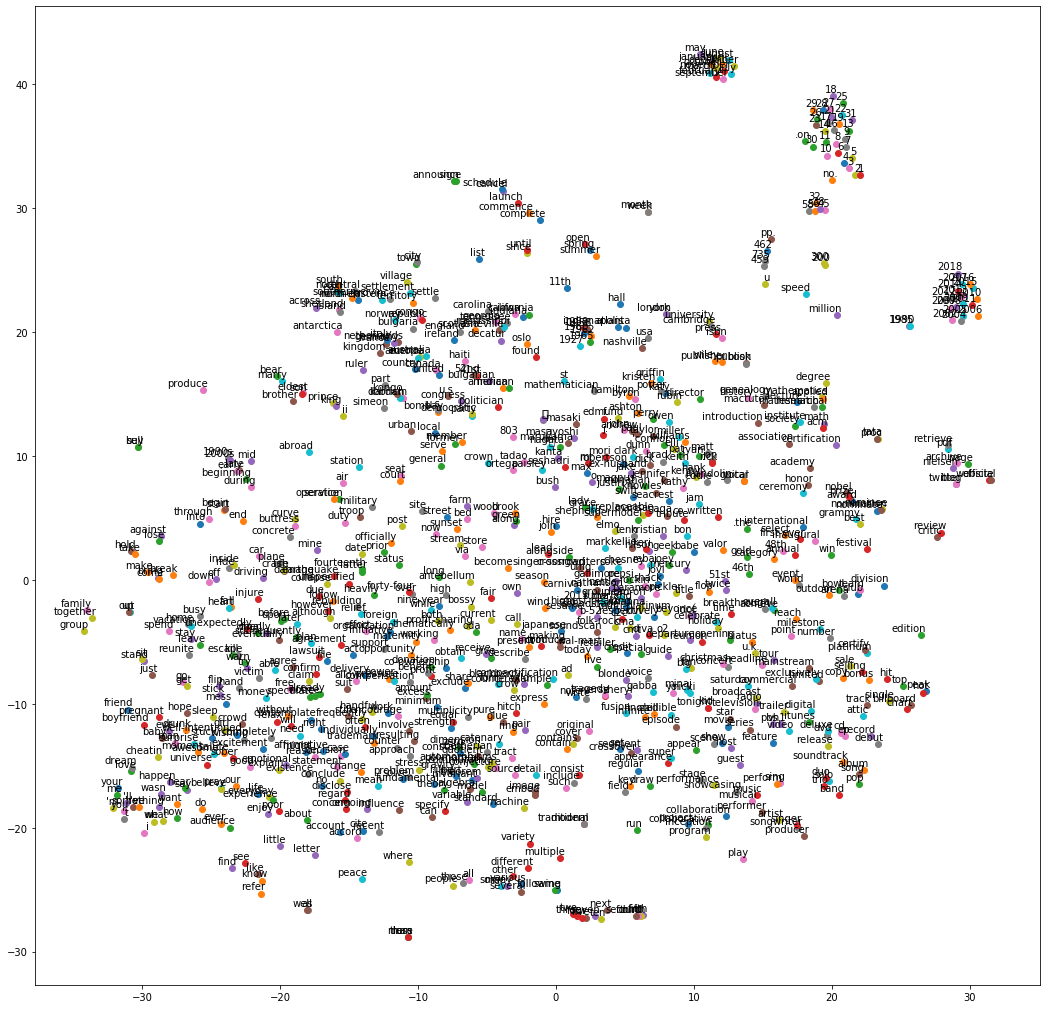

In [41]:
num_words_to_draw = len(labels)
labels_to_draw = [labels[i] for i in range(num_words_to_draw)]
a = plot_with_labels(low_dim_vectors, labels_to_draw)